# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/AS_Pool1_redo'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-AS_Pool1_redo.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam

In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/AS_Pool1_redo/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/AS_Pool1_redo/pear_merged-AS_Pool1_redo.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-AS_Pool1_redo.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 591404
Number of sequences post-filter: 582820

>MR.A.13C-Van.D30.R3_Frac26_2 orig_name=M01032:425:000000000-AR9KF:1:1101:14544:1928
TCCGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGGTAAGTTATCTGTGAAATCCC
TGGGCTCAACCTGGGCAGGTCAGTTAATACTGCTGTACTCGAGTATGGGAGAGGGTAGTGGAATTTCCGGTGTAGCGGTG
AAATGCGTAGAGATCGGAAGGACCACCAGTGGCGAAGGCGGCTACCTGGCCTAAGACGGACGCTGAGGCCCGACAGCGTG
GGGAGCAAACCGG
>MR.A.13C-Van.D30.R3_Frac7_3 orig_name=M01032:425:000000000-AR9KF:1:1101:13760:1955
TACGAAGGGGGCTAGCGTTGCTCGGAAGCACTGGGCGTAAAGCGCGCGTAGGCGGCGTTGTAAGTCGGGGGTGAAAGCCT
GTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 582820
Number of sequences post-filter: 582820


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.A.13C-Van.D30.R3_Frac26_2	MR.A.13C-Van.D30.R3_Frac26
MR.A.13C-Van.D30.R3_Frac7_3	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac20_4	MR.A.13C-Van.D30.R3_Frac20
MR.A.13C-Van.D30.R3_Frac7_5	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac27_6	MR.A.13C-Van.D30.R3_Frac27
MR.A.13C-Van.D30.R3_Frac13_7	MR.A.13C-Van.D30.R3_Frac13
MR.A.13C-Van.D30.R3_Frac7_10	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac10_12	MR.A.13C-Van.D30.R3_Frac10
MR.A.13C-Van.D30.R3_Frac7_13	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac11_15	MR.A.13C-Van.D30.R3_Frac11


In [13]:
! head -n 200 group_file.txt

MR.A.13C-Van.D30.R3_Frac26_2	MR.A.13C-Van.D30.R3_Frac26
MR.A.13C-Van.D30.R3_Frac7_3	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac20_4	MR.A.13C-Van.D30.R3_Frac20
MR.A.13C-Van.D30.R3_Frac7_5	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac27_6	MR.A.13C-Van.D30.R3_Frac27
MR.A.13C-Van.D30.R3_Frac13_7	MR.A.13C-Van.D30.R3_Frac13
MR.A.13C-Van.D30.R3_Frac7_10	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac10_12	MR.A.13C-Van.D30.R3_Frac10
MR.A.13C-Van.D30.R3_Frac7_13	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac11_15	MR.A.13C-Van.D30.R3_Frac11
MR.A.13C-Van.D30.R3_Frac19_11	MR.A.13C-Van.D30.R3_Frac19
MR.A.13C-Van.D30.R3_Frac27_16	MR.A.13C-Van.D30.R3_Frac27
MR.A.13C-Van.D30.R3_Frac13_17	MR.A.13C-Van.D30.R3_Frac13
MR.A.13C-Van.D30.R3_Frac7_14	MR.A.13C-Van.D30.R3_Frac7
MR.A.13C-Van.D30.R3_Frac22_20	MR.A.13C-Van.D30.R3_Frac22
MR.A.13C-Van.D30.R3_Frac27_18	MR.A.13C-Van.D30.R3_Frac27
MR.A.13C-Van.D30.R3_Frac28_23	MR.A.13C-Van.D30.R3_Frac28
MR.A.13C-Van.D30.R3_Frac7_22	MR.A.13C-Van.D30.R

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

561000	349250
562000	349762
563000	350238
564000	350736
565000	351199
566000	351663
567000	352111
568000	352560
569000	352989
570000	353466
571000	353980
572000	354423
573000	354910
574000	355390
575000	355879
576000	356387
577000	356851
578000	357338
579000	357824
580000	358359
581000	358831
582000	359354
582820	359836

Output File Names: 
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.names
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 359836


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 31M May 14 19:11 pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-14 19:11:13--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.90M 10s
    50K .......... .......... .......... .......... ..........  0% 1003K 14s
   100K .......... .......... .......... .......... ..........  0% 1.88M 13s
   150K .......... .......... .......... .......... ..........  1% 1002K 14s
   200K .......... .......... .......... .......... ..........  1% 1.88M 13s
   250K .......... .......... .......... .......... ..........  1%  997K 14s
   300K .......... .......... .......... .......... ..........  1% 1.87M 14s
   350K .......... .......... .......... .......... ..........  2%  995K 14s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors=24, flip=T)"'.format(qcFile3a, silvaFileFilt)
!$cmd | tail -n 30

14200
14300
14400
14500
14600
14700
14800
14900
15000
15062
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 132 secs to align 359836 sequences.


Output File Names: 
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.align
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 3.5G May 14 19:13 pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
17995



Length of filtered alignment: 993
Number of columns removed: 9187
Length of the original alignment: 10180
Number of sequences used to construct filter: 359836

Output File Names: 
pear_merged-AS_Pool1_redo.filter
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 353M May 14 19:14 pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	93	770	221	0	4	14571
25%-tile:	93	770	253	0	4	145706
Median: 	93	770	253	0	5	291411
75%-tile:	93	770	253	0	6	437116
97.5%-tile:	93	770	254	0	7	568250
Maximum:	993	993	337	0	52	582820
Mean:	93.5792	769.912	251.985	0	5.06985
# of unique seqs:	359836
total # of seqs:	582820

Output File Names: 
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.summary

It took 2 secs to summarize 582820 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [24]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 93, 770)
!$cmd | tail -n 30

Processing sequence: 16300
Processing sequence: 16400
Processing sequence: 16500
Processing sequence: 16600
Processing sequence: 16700
Processing sequence: 16800
Processing sequence: 16900
Processing sequence: 17000
Processing sequence: 17100
Processing sequence: 17200
Processing sequence: 17300
Processing sequence: 17400
Processing sequence: 17500
Processing sequence: 17600
Processing sequence: 17700
Processing sequence: 17800
Processing sequence: 17900
Processing sequence: 18000
Processing sequence: 18015

Output File Names: 
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 4 secs to screen 359836 sequences.

mothur > quit()


In [25]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 350104


In [26]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

17100
17200
17300
17400
17500
17528



Length of filtered alignment: 726
Number of columns removed: 267
Length of the original alignment: 993
Number of sequences used to construct filter: 350104

Output File Names: 
pear_merged-AS_Pool1_redo.filter
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [27]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 255M May 14 19:16 pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [28]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-AS_Pool1_redo.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [29]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [30]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	218	218	0	3	1
2.5%-tile:	1	223	223	0	4	14245
25%-tile:	1	253	253	0	4	142447
Median: 	1	253	253	0	5	284894
75%-tile:	1	253	253	0	6	427341
97.5%-tile:	1	254	254	0	7	555543
Maximum:	1	337	337	0	8	569787
Mean:	1	252.195	252.195	0	5.0468
# of Seqs:	569787

Output File Names: 
finalQC.summary

It took 0 secs to summarize 569787 sequences.

mothur > quit()


In [31]:
!head -n 6 $qcFinal

>MR.A.13C-Van.D30.R3_Frac26_2
TCCGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGGTAAGTTATCTGTGAAATCCCTGGGCTCAACCTGGGCAGGTCAGTTAATACTGCTGTACTCGAGTATGGGAGAGGGTAGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGACCACCAGTGGCGAAGGCGGCTACCTGGCCTAAGACGGACGCTGAGGCCCGACAGCGTGGGGAGCAAACCGG
>MR.A.13C-Van.D30.R3_Frac7_3
TACGAAGGGGGCTAGCGTTGCTCGGAAGCACTGGGCGTAAAGCGCGCGTAGGCGGCGTTGTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG
>MR.A.13C-Van.D30.R3_Frac20_4
TCCGAAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGCTTGTTAAGTCCGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTGGCTACTGGCAAGCTAGAGTATGGCAGAGGGGGGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGGCCGATACTGACGCGGAGGCGCGAAAGCGTGGGGAGCAAACCGG


## Summary of number of seqs per sample

In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.A.13C-Van.D30.R3_Frac26,29552
1,MR.A.13C-Van.D30.R3_Frac7,51367
2,MR.A.13C-Van.D30.R3_Frac20,26476
3,MR.A.13C-Van.D30.R3_Frac27,21101
4,MR.A.13C-Van.D30.R3_Frac13,45066
5,MR.A.13C-Van.D30.R3_Frac11,33211
6,MR.A.13C-Van.D30.R3_Frac12,24025
7,MR.A.13C-Van.D30.R3_Frac6,61418
8,MR.A.13C-Van.D30.R3_Frac17,15644
9,MR.A.13C-Van.D30.R3_Frac10,33039


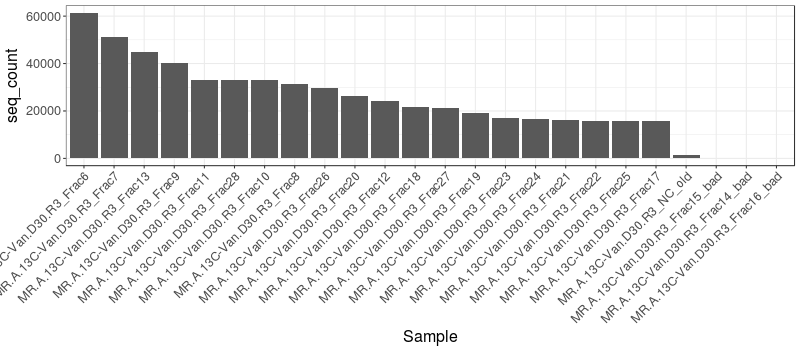

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [36]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                           Sample seq_count rank
21     MR.A.13C-Van.D30.R3_NC_old      1525    4
22 MR.A.13C-Van.D30.R3_Frac15_bad        47    3
23 MR.A.13C-Van.D30.R3_Frac14_bad        41    2
24 MR.A.13C-Van.D30.R3_Frac16_bad        36    1
